In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from datetime import date
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers.core import Activation
from keras.layers import Bidirectional

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecate

In [2]:
def parser(x):
    # return datetime
    return datetime.strptime(x, '%m/%d/%Y')

# read the csv file
dataset = pd.read_csv("Brent_Daily.csv", parse_dates=['Day'], date_parser=parser)
dataset.head(10)

dataset = dataset.sort_values('Day')
dataset = dataset.groupby('Day')['Europe Brent Spot Price FOB  Dollars per Barrel'].sum().reset_index()
dataset.set_index('Day', inplace=True)
dataset.head()

,Europe Brent Spot Price FOB Dollars per Barrel
Day,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


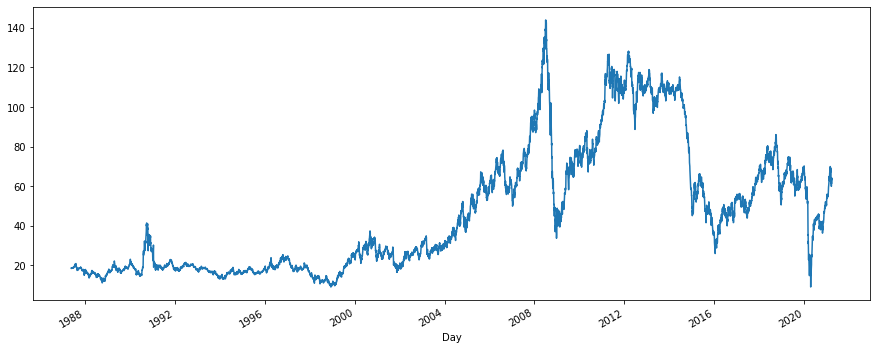

In [3]:
y = dataset['Europe Brent Spot Price FOB  Dollars per Barrel']
y.plot(figsize=(15, 6))
plt.show()

In [4]:
scaler = MinMaxScaler(feature_range = (0, 1))
df = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(df) * 0.75)
train, test = df[0:train_size, :], df[train_size:len(df), :]
valid_size = int(len(train) * 0.7)
train1, valid = train[0:valid_size, :], train[valid_size:len(train), :]

In [6]:
def create_data_set(dataset, n_steps = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - n_steps - 1):
        a = dataset[i:(i + n_steps), 0]
        data_x.append(a)
        data_y.append(dataset[i + n_steps, 0])
    return np.array(data_x), np.array(data_y)

In [7]:
n_steps = 2
n_features = 1
X_train,Y_train,X_test,Y_test,X_valid,Y_valid  = [],[],[],[],[],[]

X_train,Y_train=create_data_set(train1,n_steps)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))

X_test,Y_test=create_data_set(test,n_steps)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

X_valid,Y_valid=create_data_set(valid,n_steps)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], n_features))

In [8]:
model = Sequential()
# model.add(LSTM(50, return_sequences = False, input_shape = (n_steps, n_features)))
model.add(LSTM(20, return_sequences = True, input_shape = (n_steps, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences = False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

# call_back = EarlyStopping(monitor = 'val_loss', patience = 85, mode = 'min')
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 124, validation_data = (X_valid, Y_valid), shuffle = False)


Train on 4512 samples, validate on 1932 samples
Epoch 1/50
4512/4512 [==============================] - 1s 174us/step - loss: 0.0030 - val_loss: 0.1715
Epoch 2/50
4512/4512 [==============================] - 0s 37us/step - loss: 0.0035 - val_loss: 0.1796
Epoch 3/50
4512/4512 [==============================] - 0s 33us/step - loss: 0.0025 - val_loss: 0.1570
Epoch 4/50
4512/4512 [==============================] - 0s 36us/step - loss: 0.0024 - val_loss: 0.1363
Epoch 5/50
4512/4512 [==============================] - 0s 47us/step - loss: 0.0021 - val_loss: 0.1097
Epoch 6/50
4512/4512 [==============================] - 0s 37us/step - loss: 0.0018 - val_loss: 0.0781
Epoch 7/50
4512/4512 [==============================] - 0s 39us/step - loss: 0.0014 - val_loss: 0.0444
Epoch 8/50
4512/4512 [==============================] - 0s 40us/step - loss: 9.8199e-04 - val_loss: 0.0157
Epoch 9/50
4512/4512 [==============================] - 0s 43us/step - loss: 5.9032e-04 - val_loss: 0.0015
Epoch 10/50
451

In [9]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

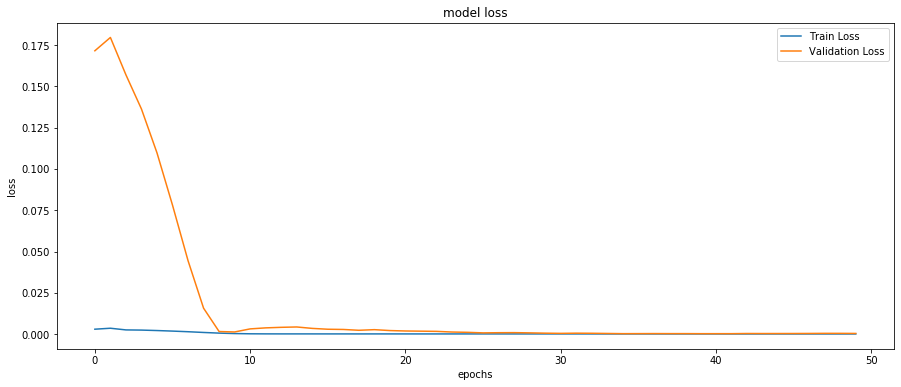

In [10]:
plt.figure(figsize = (15,6))
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')
plt.show();

In [11]:
# # invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [12]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))

Train Mean Absolute Error: 0.46091254286732225
Test Mean Absolute Error: 1.4103899727187346


In [13]:
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Root Mean Squared Error: 0.7058840536134564
Test Root Mean Squared Error: 1.8412339666350361


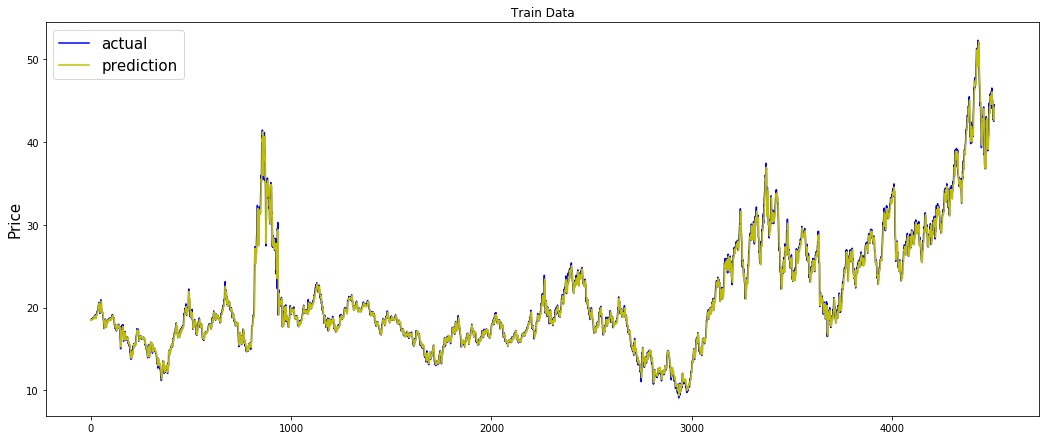

In [14]:
# Compare train data Actual vs. Prediction
plt.style.context("seaborn-white")
plt.figure(figsize=(15,6))
plt.plot(Y_train[0], 'b', label="actual")
plt.plot(train_predict, 'y', label="prediction")
plt.tight_layout()
plt.title('Train Data')
# sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.legend(fontsize=15)
plt.show();

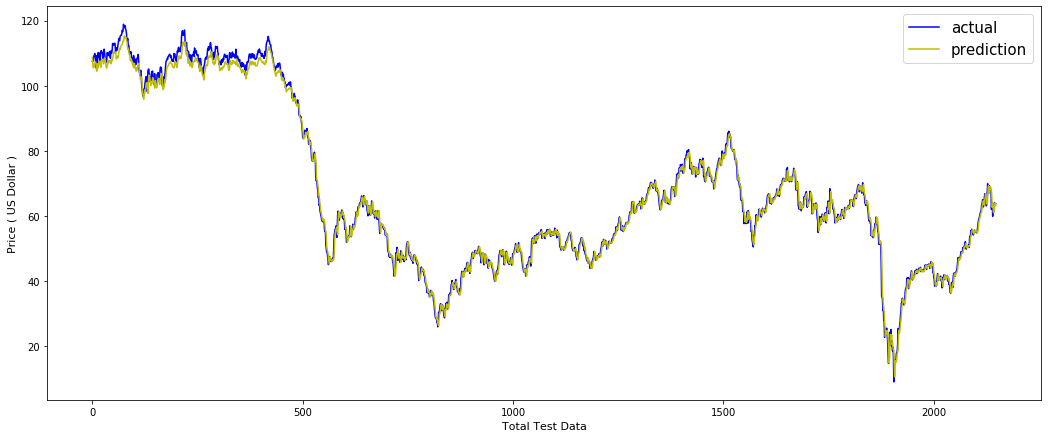

In [15]:
# Compare test data Actual vs. Prediction
plt.figure(figsize=(15,6))
plt.plot(Y_test[0], 'b', label="actual")
plt.plot(test_predict, 'y', label="prediction")
plt.tight_layout()
# sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price ( US Dollar )', size=11)
plt.xlabel('Total Test Data', size=11)
plt.legend(fontsize=15)
plt.show();